#### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Conv1D
import matplotlib.pyplot as plt
%matplotlib inline

#### Read csv and select the stock for which you wanna predict future price

In [2]:
df = pd.read_csv('prices-split-adjusted.csv')
pg = df[df['symbol'] == 'HAL']  ## change 'HAL' with your choice of stock 
pg

,date,symbol,open,close,low,high,volume
448,2010-01-04,HAL,30.719999,31.250000,30.660000,31.340000,11571600.0
916,2010-01-05,HAL,31.280001,31.650000,30.990000,31.830000,18989700.0
1384,2010-01-06,HAL,31.740000,32.400002,31.639999,32.590000,15720800.0
1852,2010-01-07,HAL,32.310001,32.480000,31.920000,32.520000,8993100.0
2320,2010-01-08,HAL,32.950001,34.119999,32.490002,34.139999,23014600.0
...,...,...,...,...,...,...,...
848972,2016-12-23,HAL,55.040001,54.840000,54.630001,55.259998,3161500.0
849472,2016-12-27,HAL,55.020000,54.910000,54.700001,55.540001,3608700.0
849972,2016-12-28,HAL,55.110001,54.299999,54.180000,55.220001,4759700.0
850472,2016-12-29,HAL,54.139999,54.040001,53.840000,54.459999,4216800.0


In [3]:
pg.drop('symbol', axis = 1,  inplace=True)
pg.drop('open', axis = 1,  inplace=True)
pg.drop('low', axis = 1,  inplace=True)
pg.drop('high', axis = 1,  inplace=True)
pg.drop('volume', axis = 1,  inplace=True)
pg.drop('date', axis = 1,  inplace=True)

c:\users\kaust\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### At this point we can include different technical indicators like moving averages, bollinger bands, RSI etc, but I found that raw data worked out the best with least RMS 

### I have included "Exponential Moving Average" in another code, you can check it out there

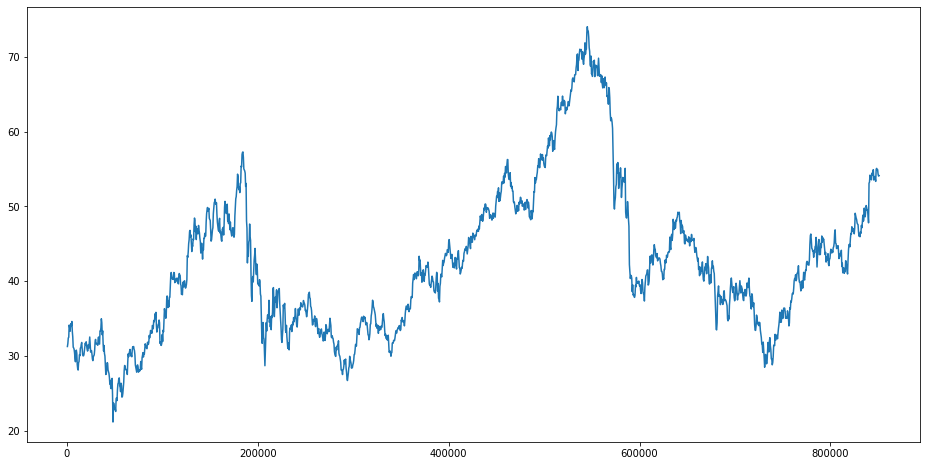

In [4]:
plt.figure(figsize=(16,8))
plt.plot(pg['close'], label='Close Price history')

In [5]:
dataset = pg.values
train = dataset[0:1500,:]
valid = dataset[1500:,:]

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Normalize the data
scaled_data = scaler.fit_transform(dataset)

#### Now we set our training data, I will feed the data of last 60 days to predict the new price, you can try your version of code with any other choice for number of days.

#### If you increase the number of days the network will take longer time to learn.

#### I've tried 30 days, 60 days and 90 days, and I have noticed that the rms(root mean square) error do not decrease significantly after 60 days.

In [7]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#### The model, 2 dense layers with activation function 'tanh', a Convolutional 1D layer and a Bidirectional LSTM and finally and output layer. 

#### I tried varying the number of layers from single LSTM layer to upto 4 dense layer with different number of nodes in each layer, activation functions like 'relu', 'tanh', 'sigmoid' and their combinations, and found that the following model works the best.

#### I also tried dropout in hope to improve the results but it doesn't work out as I expected. 

In [8]:
model = Sequential()
model.add(Dense(20,activation='tanh'))
model.add(Dense(10,activation='tanh'))
model.add(Conv1D(filters=32, kernel_size=3,strides=1, padding="causal", activation="relu", input_shape=[None, 1]))
model.add(Bidirectional(LSTM(units=32)))
model.add(Dense(1))

#### I tried various optimizers, epoch number and batch size.

#### Adam works very good and fast, loss after 100 epochs never reduced significantly.

In [9]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
history = model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=1, validation_split = 0.15)

Epoch 1/100
10/10 [==============================] - 30s 372ms/step - loss: 0.0835 - mae: 0.2165 - val_loss: 0.0326 - val_mae: 0.1741
Epoch 2/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0199 - mae: 0.1169 - val_loss: 0.0026 - val_mae: 0.0404
Epoch 3/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0115 - mae: 0.0813 - val_loss: 0.0023 - val_mae: 0.0383
Epoch 4/100
10/10 [==============================] - 1s 91ms/step - loss: 0.0062 - mae: 0.0611 - val_loss: 0.0036 - val_mae: 0.0490
Epoch 5/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0041 - mae: 0.0479 - val_loss: 0.0014 - val_mae: 0.0284
Epoch 6/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0032 - mae: 0.0407 - val_loss: 0.0014 - val_mae: 0.0281
Epoch 7/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0027 - mae: 0.0387 - val_loss: 0.0013 - val_mae: 0.0272
Epoch 8/100
10/10 [==============================] - 1s 93ms/step - loss: 

Epoch 60/100
10/10 [==============================] - 1s 89ms/step - loss: 5.1975e-04 - mae: 0.0169 - val_loss: 4.0359e-04 - val_mae: 0.0148
Epoch 61/100
10/10 [==============================] - 1s 93ms/step - loss: 5.1479e-04 - mae: 0.0166 - val_loss: 3.9643e-04 - val_mae: 0.0147
Epoch 62/100
10/10 [==============================] - 1s 88ms/step - loss: 4.9753e-04 - mae: 0.0165 - val_loss: 4.1988e-04 - val_mae: 0.0154
Epoch 63/100
10/10 [==============================] - 1s 89ms/step - loss: 4.8878e-04 - mae: 0.0162 - val_loss: 3.9191e-04 - val_mae: 0.0147
Epoch 64/100
10/10 [==============================] - 1s 91ms/step - loss: 4.7778e-04 - mae: 0.0163 - val_loss: 3.9594e-04 - val_mae: 0.0148
Epoch 65/100
10/10 [==============================] - 1s 89ms/step - loss: 4.6961e-04 - mae: 0.0160 - val_loss: 3.7955e-04 - val_mae: 0.0144
Epoch 66/100
10/10 [==============================] - 1s 92ms/step - loss: 4.7220e-04 - mae: 0.0161 - val_loss: 3.8458e-04 - val_mae: 0.0145
Epoch 67/100


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60, 20)            40        
                                                                 
 dense_1 (Dense)             (None, 60, 10)            210       
                                                                 
 conv1d (Conv1D)             (None, 60, 32)            992       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,947
Trainable params: 17,947
Non-trainable params: 0
____________________________________________________

#### Test set

In [11]:
inputs = pg[len(pg) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

#### ROOT MEAN SQUARED ERROR

In [12]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.9110741838883797

#### MEAN ABSOLUTE ERROR

In [13]:
mae=(np.mean(abs(valid-closing_price)))
mae

0.6920477682322728

<ipython-input-14-e5ebdeb26b25>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


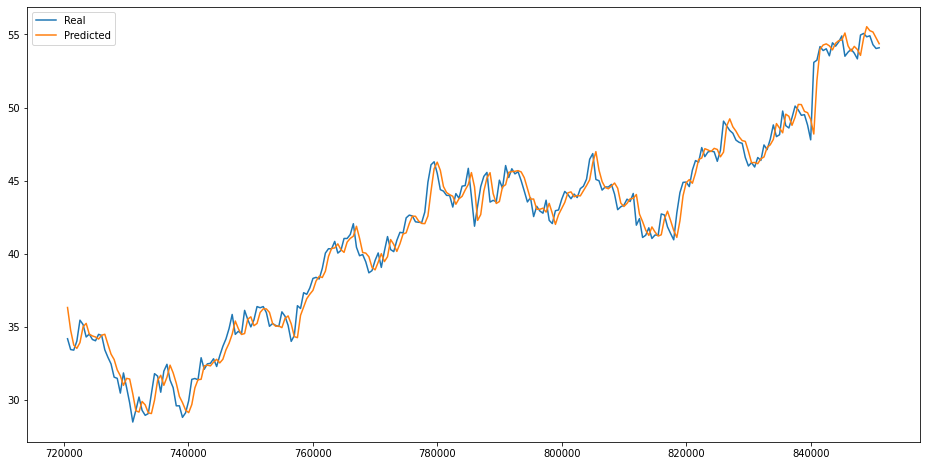

In [14]:
train = pg[:1500]
valid = pg[1500:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(valid[['close','Predictions']]) # predictions over test set
plt.legend(['Real', 'Predicted'])

In [15]:
s = pg[len(pg) - 60:].values
s = s.reshape(-1,1)
s = scaler.transform(s)

In [16]:
s = np.reshape(s, (s.shape[1],s.shape[0],1))
closing_price = model.predict(s)
closing_price = scaler.inverse_transform(closing_price)
closing_price # next day closing price

array([[54.36455]], dtype=float32)